# Examining factors that influence in European voters

## Leave or remain in the European Union? 

<img src='https://www.irishtimes.com/polopoly_fs/1.3657023.1539082433!/image/image.jpg' style='height:400px'/>

Photo: The Irish Times — [BREXIT: THE FACTS](https://www.irishtimes.com/news/world/brexit/brexit-the-facts)

### <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">Table of Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Dictionary](#1.1)
    * [1.2 Survey Questions](#1.2)
    * [1.3 International Standard Classification of Education (ISCED)](#1.3)
    * [1.4 Notebook settings](#1.4)
    * [1.5 Libraries](#1.5)
    * [1.6 Loading Dataset](#1.6)
* [2. Data Cleaning & Wrangling](#2)
    * [2.1 Handle Missings](#2.1)
    * [2.2 Data Transformation / Aggregation](#2.2)
    * [2.3 European Regions](#2.3)
* [3. Survey Weights](#3)
* [4. Exploratory Data Analysis](#4)
    * [4.1 Autocorrelation Analysis](#4.1)
* [5. Modeling](#5)
    * [5.1 Models for Univariate Time Series](#5.1)
        * [5.1.1 Univariate Prophet](#5.1.1)
        * [5.1.2 ARIMA](#5.1.2)
        * [5.1.3 Auto-ARIMA](#5.1.3)
        * [5.1.4 LSTM](#5.1.4)
    * [5.2 Models for Multivariate Time Series](#5.2)
        * [5.1.1 Multivariate Prophet](#5.2.1)
* [6. Conclusions](#6)
* [7. References](#7)


<a id="1"></a> <br>
<font size="+3" color="black"><b>1 - Introduction</b></font><br><a id="1"></a>
<br> 

This analysis will investigated a dataset provided by [European Social Survey (ESS)](https://www.europeansocialsurvey.org/) which is a cross-national survey of attitudes and behaviour from European citizens. The topics covered by ESS are very heterogeneous and include media and social trust, politics, immigration, citizen involvement, health and care, economic, work and well-being.

The analysis will focus on which aspects can influence a person vote for your country leave or remain a member of the European Union. The variables selected are mostly socio-demographic such as education, employment status and Union membership status.


<a id='1.1'></a>
## Data Dictionary

- __CNTRY__ Country
- __EDUYRS__ Years of full-time education completed
- __EISCED__ Highest level of education, ES - ISCED
- __UEMP3M__ Ever unemployed and seeking work for a period more than three months
- __MBTRU__ Member of trade union or similar organisation
- __VTEURMMB__ Would vote for your country to remain member of European Union or leave
- __GNDR__ Gender
- __YRBRN__  Year of birth
- __AGEA__ Age of respondent. Calculation based on year of birth and year of interview

<a id='1.2'></a>
## Survey Questions

**EDUYR** About how many years of education have you completed, whether full-time or part-time? Please report these in full-time equivalents and include compulsory years of schooling.
<br>**EISCED** Generated variable: Highest level of education, ES - ISCED 9 (What is the highest level of education you have successfully completed?)
<br>**UEMP3M** Have you ever been unemployed and seeking work for a period of more than three months?
<br>**MBTRU** Are you or have you ever been a member of a trade union or similar organisation? IF YES, is that currently or previously?
<br>**VTEURMMB** Imagine there were a referendum in [country] tomorrow about membership of the European Union. Would you vote for [country] to remain a member of the European Union or to leave the European Union?
<br>**YRBRN** And in what year were you born?

<a id='1.3'></a>
## International Standard Classification of Education (ISCED)

ISCED is the reference international classification for organising education programmes and related qualifications by levels and fields. ISCED 2011 (levels of education) has been implemented in all EU data collections
since 2014.

__Levels__

- ISCED 0: Early childhood education (‘less than primary’ for educational attainment)
- ISCED 1: Primary education
- ISCED 2: Lower secondary education
- ISCED 3: Upper secondary education
- ISCED 4: Post-secondary non-tertiary education
- ISCED 5: Short-cycle tertiary education
- ISCED 6: Bachelor’s or equivalent level
- ISCED 7: Master’s or equivalent level
- ISCED 8: Doctoral or equivalent level

More info about ISCED can be found [here](https://ec.europa.eu/eurostat/statistics-explained/index.php/International_Standard_Classification_of_Education_(ISCED)).

<a id='1.4'></a>
## Notebook settings

In [160]:
# Change the default plots size 
options(repr.plot.width=15, repr.plot.height=10)
options(warn=-1)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

<a id='1.5'></a>
## Libraries

In [159]:
# Check if the packages that we need are installed
want = c("dplyr", "ggplot2", "ggthemes", "gghighlight", "foreign", "scales", "survey", "srvyr", "caret", 
         "ggpubr", "forcats")
have = want %in% rownames(installed.packages())
# Install the packages that we miss
if ( any(!have) ) { install.packages( want[!have] ) }
# Load the packages
junk <- lapply(want, library, character.only = T)
# Remove the objects we created
rm(have, want, junk)

<a id='1.6'></a>
## Loading dataset

__Selecting the variables which will be used for the data analysis__

In [4]:
survey_rawdata <- read.spss("ESS9e03_1.sav", use.value.labels=T, max.value.labels=Inf, to.data.frame=TRUE)

In [5]:
variables <- c("cntry", 
               "eduyrs", 
               "eisced",
               "uemp3m", 
               "mbtru", 
               "vteurmmb", 
               "yrbrn", 
               "agea", 
               "gndr", 
               "anweight", 
               "psu", 
               "stratum")

In [6]:
european_survey <- survey_rawdata[,variables]

In [7]:
head(european_survey)

,cntry,eduyrs,eisced,uemp3m,mbtru,vteurmmb,yrbrn,agea,gndr,anweight,psu,stratum
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,Austria,12,"ES-ISCED IIIb, lower tier upper secondary",No,No,Remain member of the European Union,1975,43,Male,0.06588958,1688,59
2,Austria,12,"ES-ISCED IIIb, lower tier upper secondary",No,"Yes, previously",Remain member of the European Union,1951,67,Male,0.12490674,88,79
3,Austria,12,"ES-ISCED II, lower secondary",No,No,Leave the European Union,1978,40,Female,0.68583600,938,11
4,Austria,11,"ES-ISCED IIIb, lower tier upper secondary",No,No,Remain member of the European Union,1955,63,Male,0.11675334,1998,74
5,Austria,8,"ES-ISCED II, lower secondary",No,No,Remain member of the European Union,1947,71,Female,0.31178924,601,99
6,Austria,13,"ES-ISCED IIIb, lower tier upper secondary",No,"Yes, previously",Remain member of the European Union,1954,64,Male,0.17386711,68,77


In [8]:
paste0("Number of rows in the dataset: ", nrow(european_survey))

[1] "Number of rows in the dataset: 49519"

<a id="2"></a> <br>
<font size="+3" color="black"><b>2 - Data Cleaning & Wrangling</b></font><br><a id="2"></a>
<br> 

In [9]:
# Checking for NA's in the dataset
sapply(european_survey, function(x) sum(is.na(x)))

cntry   eduyrs   eisced   uemp3m    mbtru vteurmmb    yrbrn     agea 
       0      708      107      295      331    13648      222      222 
    gndr anweight      psu  stratum 
       0        0        0        0

<a id='2.1'></a>
## Handle Missings

In [10]:
# For the purpose of this analysis, considering Vote as Leave or Remain
european_survey$vteurmmb <- as.character(european_survey$vteurmmb)
european_survey$vteurmmb[european_survey$vteurmmb == "Remain member of the European Union"] <- "Remain"
european_survey$vteurmmb[european_survey$vteurmmb == "Leave the European Union"] <- "Leave"
european_survey$vteurmmb[european_survey$vteurmmb == "Would submit a blank ballot paper"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Would spoil the ballot paper"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Would not vote"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Not eligible to vote"] <- NA
european_survey$vteurmmb <- as.factor(european_survey$vteurmmb)

In [11]:
# Cleaning responses that are not able to fit into ISCED
european_survey$eisced <- as.character(european_survey$eisced)
european_survey$eisced[european_survey$eisced == "Not possible to harmonise into ES-ISCED"] <- NA
european_survey$eisced[european_survey$eisced == "Other"] <- NA

In [13]:
# Cleaning NA values
df_european_survey <- european_survey[complete.cases(european_survey), ]
sapply(df_european_survey, function(x) sum(is.na(x)))

cntry    eduyrs    eisced    uemp3m     mbtru  vteurmmb     yrbrn      agea 
        0         0         0         0         0         0         0         0 
     gndr  anweight       psu   stratum Education 
        0         0         0         0         0

In [14]:
# Different way to clean the variable leaving as yes or no
df_european_survey$uemp3m <- as.character(df_european_survey$uemp3m)
df_european_survey$uemp3m <- as.factor(df_european_survey$uemp3m)

<a id='2.2'></a>
## Data Transformation / Aggregation
### Aggregation Levels by EISCED

| Level            | ISCED      |
| :-----------:    |:----------:|
| Low education    | Levels 0-2 |
| Medium education | Levels 3-4 |
| High education   | Levels 5-8 |

In [12]:
# Creating a new feature Education by aggregating the ISCED"s levels
# Low, Medium and High Education
european_survey <- european_survey %>% 
  mutate(Education = case_when(
      eisced == "ES-ISCED I , less than lower secondary" ~ "Low Education",
      eisced == "ES-ISCED II, lower secondary" ~ "Low Education",
      eisced == "ES-ISCED IIIb, lower tier upper secondary" ~ "Medium Education",
      eisced == "ES-ISCED IIIa, upper tier upper secondary" ~ "Medium Education",
      eisced == "ES-ISCED IV, advanced vocational, sub-degree" ~ "Medium Education",
      eisced == "ES-ISCED V1, lower tertiary education, BA level" ~ "High Education",
      eisced == "ES-ISCED V2, higher tertiary education, >= MA level" ~ "High Education",
      TRUE ~ eisced))
european_survey$Education <- as.factor(european_survey$Education)
european_survey$eisced <- as.factor(european_survey$eisced)

In [15]:
# For the purpose of this analysis, considering the answer if the respondent ever been a member 
# of a trade union or similar organisation - "Yes, currently" and "Yes, previously" as simple Yes
df_european_survey$mbtru <- as.character(df_european_survey$mbtru)
df_european_survey$mbtru[df_european_survey$mbtru == "Yes, currently"] <- "Yes"
df_european_survey$mbtru[df_european_survey$mbtru == "Yes, previously"] <- "Yes"
df_european_survey$mbtru <- as.factor(df_european_survey$mbtru)


In [16]:
# Transforming as numeric the variable Years of Education
df_european_survey$eduyrs <- as.numeric(df_european_survey$eduyrs)

In [17]:
# Creating a new feature as per age (eg. young, young adult, older adult, elderly)
df_european_survey$agea <- as.numeric(df_european_survey$agea)
df_european_survey <- df_european_survey %>% 
  mutate(Age_Band = case_when(
    agea < 20 ~ "<20",
    agea >= 20 & agea < 40 ~ "20-39",
    agea >= 40 & agea <= 65 ~ "40-65",
    agea > 65 ~ ">65"))
df_european_survey$Age_Band <- as.factor(df_european_survey$Age_Band)

<a id='2.3'></a>
## European Regions

Conventionally there are four main geographical regions or subregions in Europe.

- Northern Europe
- Western Europe
- Eastern Europe
- Southern Europe

__Northern Europe__ refers to the portion of Europe to the north of Western Europe, the English Channel, and the Baltic Sea; it also includes the Baltic republics of Estonia, Latvia, and Lithuania.

__Western Europe__ is bounded by the Atlantic Ocean in the west, the English Channel and the North Sea to the north, and by the Alps in the south.

Conventionally __Eastern Europe__ is the geographical region east of Germany and west of the Ural Mountains. The United Nations geoscheme lists ten countries including the former Eastern bloc countries of Poland, Czechia, and Slovakia (formerly Czechoslovakia), Hungary, Romania, and Bulgaria, the former Soviet republics of Belarus and Ukraine, as well as European Russia.

__Southern Europe__ or Mediterranean Europe refers to the mainly subtropical southern portion of the continent. The region is bounded by the Mediterranean Sea in the south. There are 13 sovereign countries in Southern Europe; seven of those states are members of the European Union.

In [18]:
northern <- c("Denmark","Finland","Ireland","Latvia","Lithuania","Sweden")
western <- c("Austria","Belgium","France","Germany","Netherlands")
eastern <- c("Bulgaria","Czechia","Hungary","Poland","Slovakia")
southern <- c("Slovenia","Cyprus","Spain","Croatia","Italy","Portugal")
df_european_survey <- df_european_survey %>% mutate(Region = case_when(cntry %in% northern ~ "Northern Europe",
                                                                      cntry %in% western ~ "Western Europe",
                                                                      cntry %in% eastern ~ "Eastern Europe",
                                                                      cntry %in% southern ~ "Southern Europe",
                                                                      TRUE ~ "Europe"))

<a id="3"></a> <br>
<font size="+3" color="black"><b>3 - Survey Weights</b></font><br><a id="3"></a>
<br> 

The analysis of survey data often uses complex sample designs and __weighting adjustments__ in order to make the sample look more like the intended population of the survey. As ESS is a __cross-national survey__ and countries implement different sample designs, it is important to use weights in all analysis to take into consideration the country context, and therefore __avoid bias in the outcome__.

__Post-stratification weights__ intended purpose is to decrease the impact of coverage, sampling and nonresponse error. In ESS is based on gender, age, education and geographical region.

__Clustering__ produces more precise population estimates than a simple random design would achieve but this makes survey results appear more homogeneous. To address this problem ESS uses Clustering Adjustments.

According to ESS documentation:

> It is recommended that by default you should always use *anweight* (analysis 
weight) as a weight in all analysis. This weight is suitable for all types of analysis, 
including when you are studying just one country, when you compare across 
countries, or when you are studying groups of countries. 

> *anweight* corrects for differential selection probabilities within each country as 
specified by sample design, for nonresponse, for noncoverage, and for sampling 
error related to the four post-stratification variables, and takes into account 
differences in population size across countries. 

Details about how ESS weights the data can be found [here](https://www.europeansocialsurvey.org/docs/methodology/ESS_weighting_data_1_1.pdf).

There are 2 R packages which help us with complex surveys design: `survey` and `srvyr`

In ESS dataset the clustering variable is _psu_, stratification is indicated by _stratum_, and weighting by _anweight_.

`srvyr` library which is based on `survey` brings a _dplyr_ syntax-style.

In [19]:
weighted_df_ess <- df_european_survey %>% as_survey_design(ids=psu, strata=stratum, weights=anweight)

In [20]:
# Lonely PSUs - http://r-survey.r-forge.r-project.org/survey/exmample-lonely.html
options(survey.lonely.psu = "adjust")

In [21]:
weighted_df_ess

Stratified 1 - level Cluster Sampling design (with replacement)
With (16284) clusters.
Called via srvyr
Sampling variables:
 - ids: psu
 - strata: stratum
 - weights: anweight
Data variables: cntry (fct), eduyrs (dbl), eisced (fct), uemp3m (fct), mbtru
  (fct), vteurmmb (fct), yrbrn (fct), agea (dbl), gndr (fct), anweight (dbl),
  psu (dbl), stratum (dbl), Education (fct), Age_Band (fct), Region (chr)

<a id="4"></a> <br>
<font size="+3" color="black"><b>4 - Data Exploration</b></font><br><a id="4"></a>
<br> 

In [99]:
# Classifying happiness with EU by splitting countries with more than 15% of voting to Leave as Unfavorable
happiness_EU <- weighted_df_ess %>% 
                    group_by(cntry,vteurmmb) %>%
                    summarise(proportion = survey_mean()) %>%
                    filter(vteurmmb == "Leave") %>% 
                    mutate(EU_Opinion = ifelse(proportion < .16, "Favorable", "Unfavorable")) %>%
                    group_by(EU_Opinion) %>% summarise(total = n()) %>%
                    mutate(prop = total / sum(total), 
                           label = paste0(round(total / sum(total) * 100, 0), "%"), 
                           label_y = cumsum(prop) - 0.5 * prop)

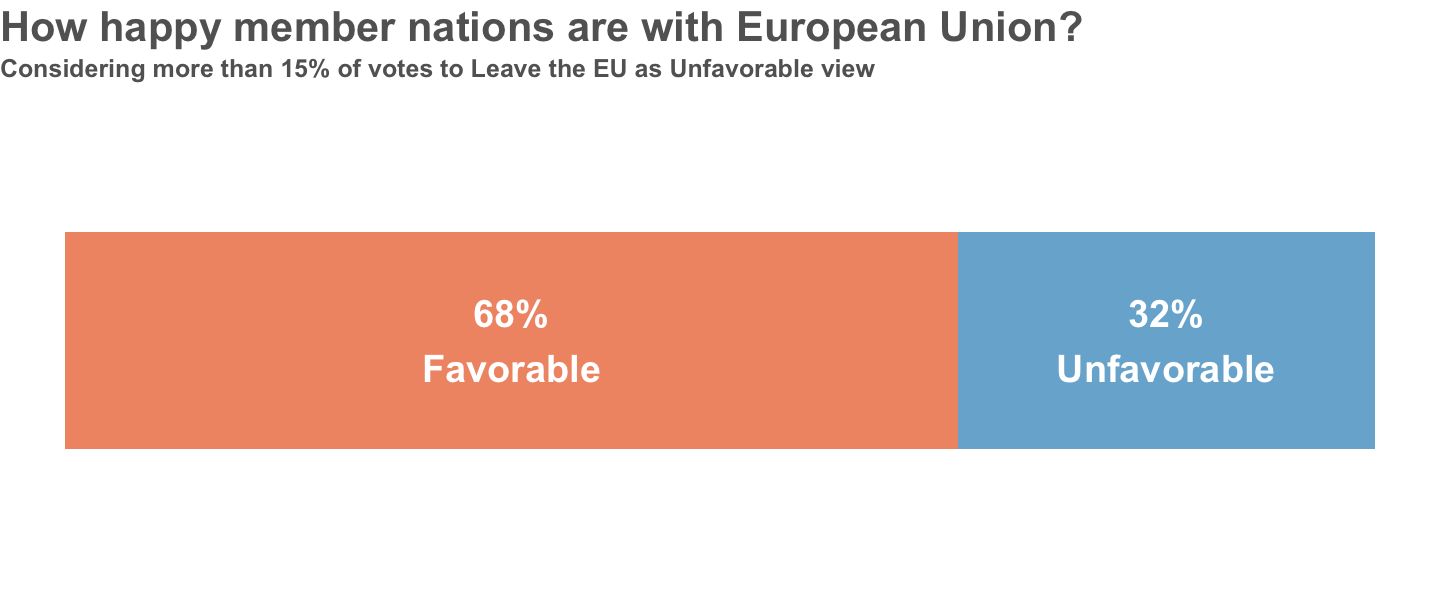

In [151]:
options(repr.plot.width=12, repr.plot.height=5)
happiness_EU %>%
    ggplot(aes(x = "", y = prop)) +
    geom_bar(aes(fill = fct_reorder(EU_Opinion, prop, .desc = FALSE)), lineend = 'round',
             stat = "identity", width = .5, alpha=.9) +
    coord_flip() +
    scale_fill_manual(values = c("#67a9cf", "#ef8a62")) +
    geom_text(aes(y = label_y, label = paste0(label, "\n", EU_Opinion)), size = 8, col = "white", fontface = "bold") +
    labs(x = "", y = "%",
        title = "How happy member nations are with European Union?",
        subtitle = "Considering more than 15% of votes to Leave the EU as Unfavorable view") + 
    theme_void() +
    theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
    theme(legend.position = "none",
          plot.title=element_text(vjust=.8,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.8,family='', face='bold', colour='#636363', size=15))

#ef8a62 - Happy
#67a9cf - Not so Happy

__The majority of countries surveyed have shown a favorable view regarding the European Union however, not everyone is happy with the institution. Across the 22 EU member countries surveyed on this analysis, a median of 32% hold an unfavorable view.__

In [152]:
# changing the global plot size back
options(repr.plot.width=15, repr.plot.height=10)

## Countries with the highest proportion of votes to Leave the EU

In [153]:
countries_by_Vote_Leave <- weighted_df_ess %>% group_by(cntry,vteurmmb) %>% 
    summarise(total = survey_total(), prop = survey_mean()) %>%
    filter(vteurmmb == "Leave") %>%
    arrange(desc(prop)) %>%
    head(15)

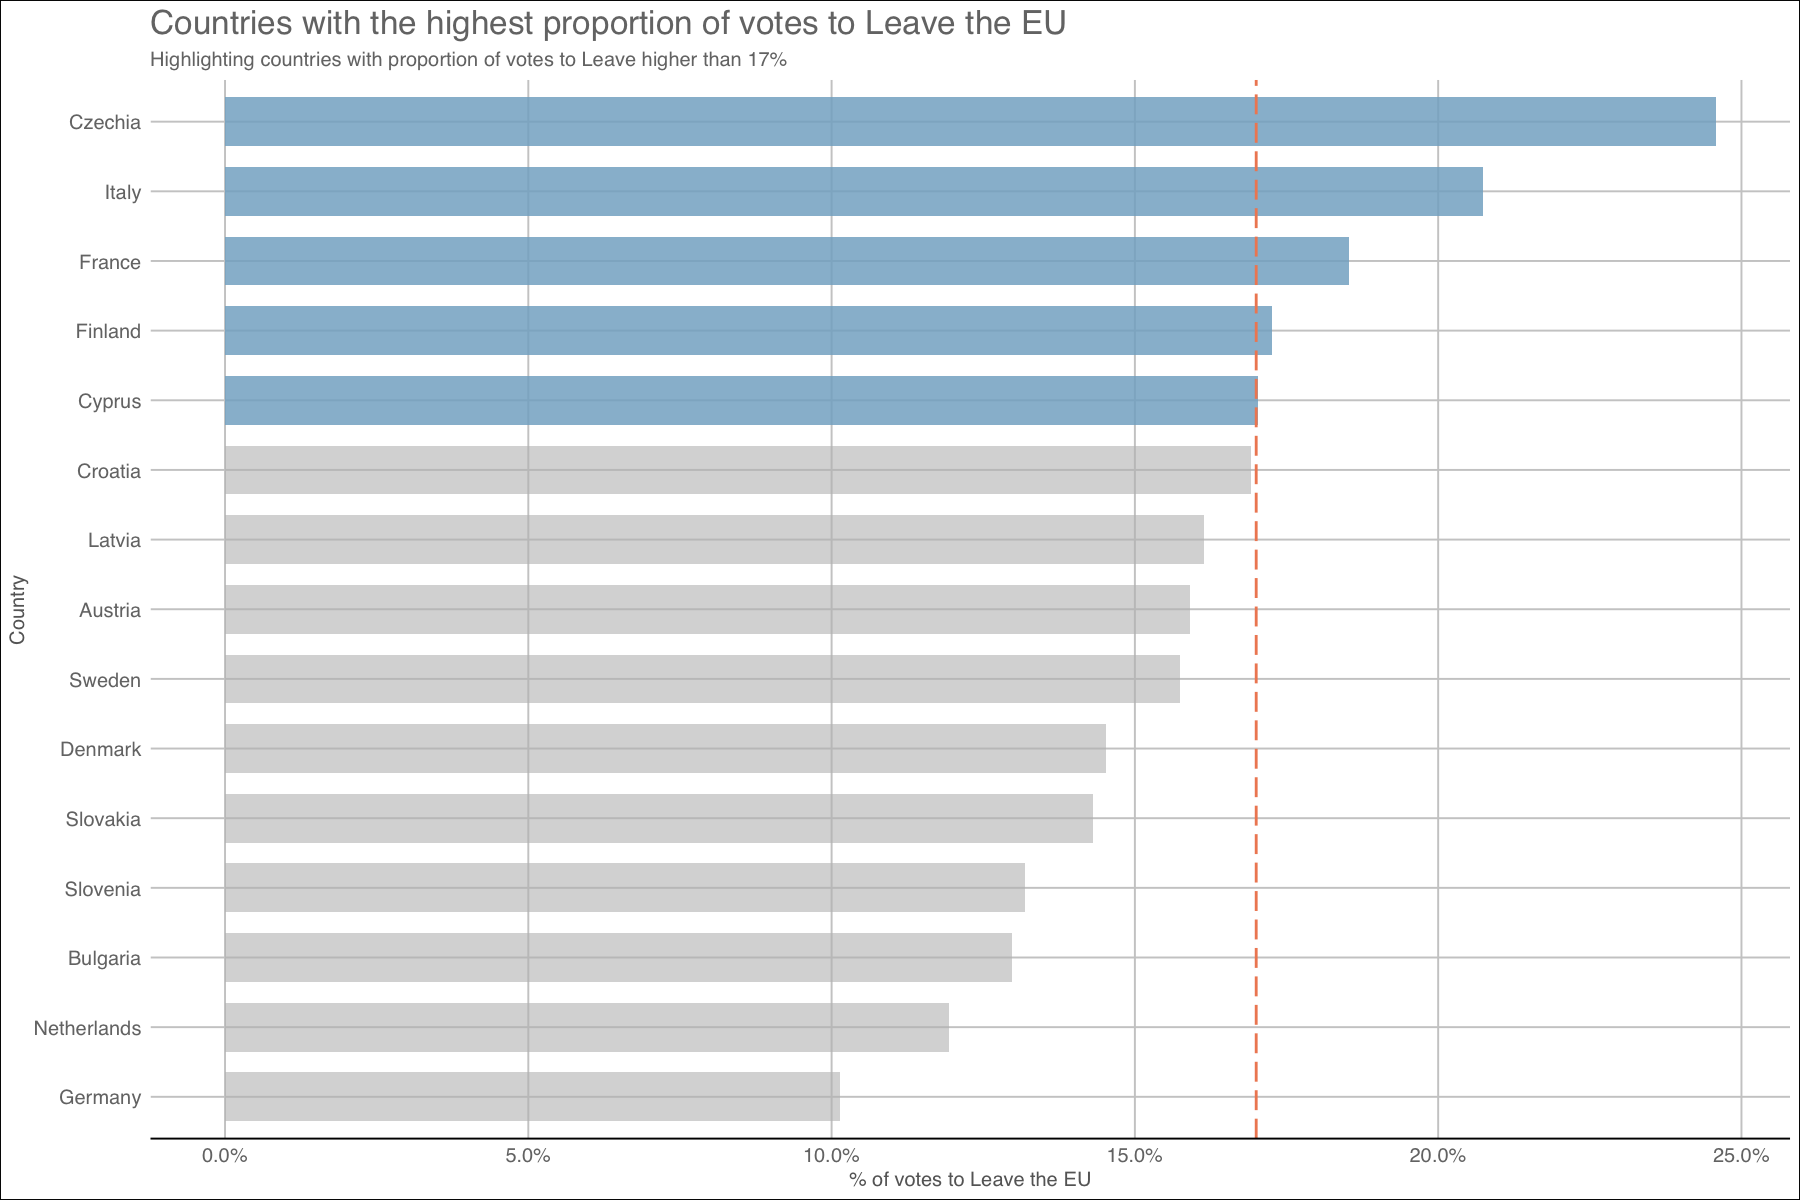

In [158]:
countries_by_Vote_Leave %>%
ggplot(aes(x=factor(cntry, levels = countries_by_Vote_Leave$cntry[order(prop)]), y=prop)) + 
    geom_bar(position="dodge",stat="identity", width = .7, fill="#67a9cf", alpha = .6) +
    gghighlight(max(prop) > 0.17) +
    geom_hline(aes(yintercept = 0.17), colour = "#ef8a62", linetype ="longdash", size = .8) +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "Country",
         y = "% of votes to Leave the EU",
         title = "Countries with the highest proportion of votes to Leave the EU",
         subtitle = "Highlighting countries with proportion of votes to Leave higher than 17%") +
    theme_gdocs() + coord_flip()

The countries with the highest proportion of votes to leave the EU are Czechia, Italy, France, Finland and Cyprus. With **more than 17%** of the respondents predisposed to vote for their country to **Leave the EU** on a hypothetical referendum.  

## Countries with the highest proportion of votes to Remain member of the EU

In [155]:
countries_by_Vote_Remain <- weighted_df_ess %>% group_by(cntry,vteurmmb) %>% 
    summarise(total = survey_total(), prop = survey_mean()) %>%
    filter(vteurmmb == "Remain") %>%
    arrange(desc(prop)) %>%
    head(15)

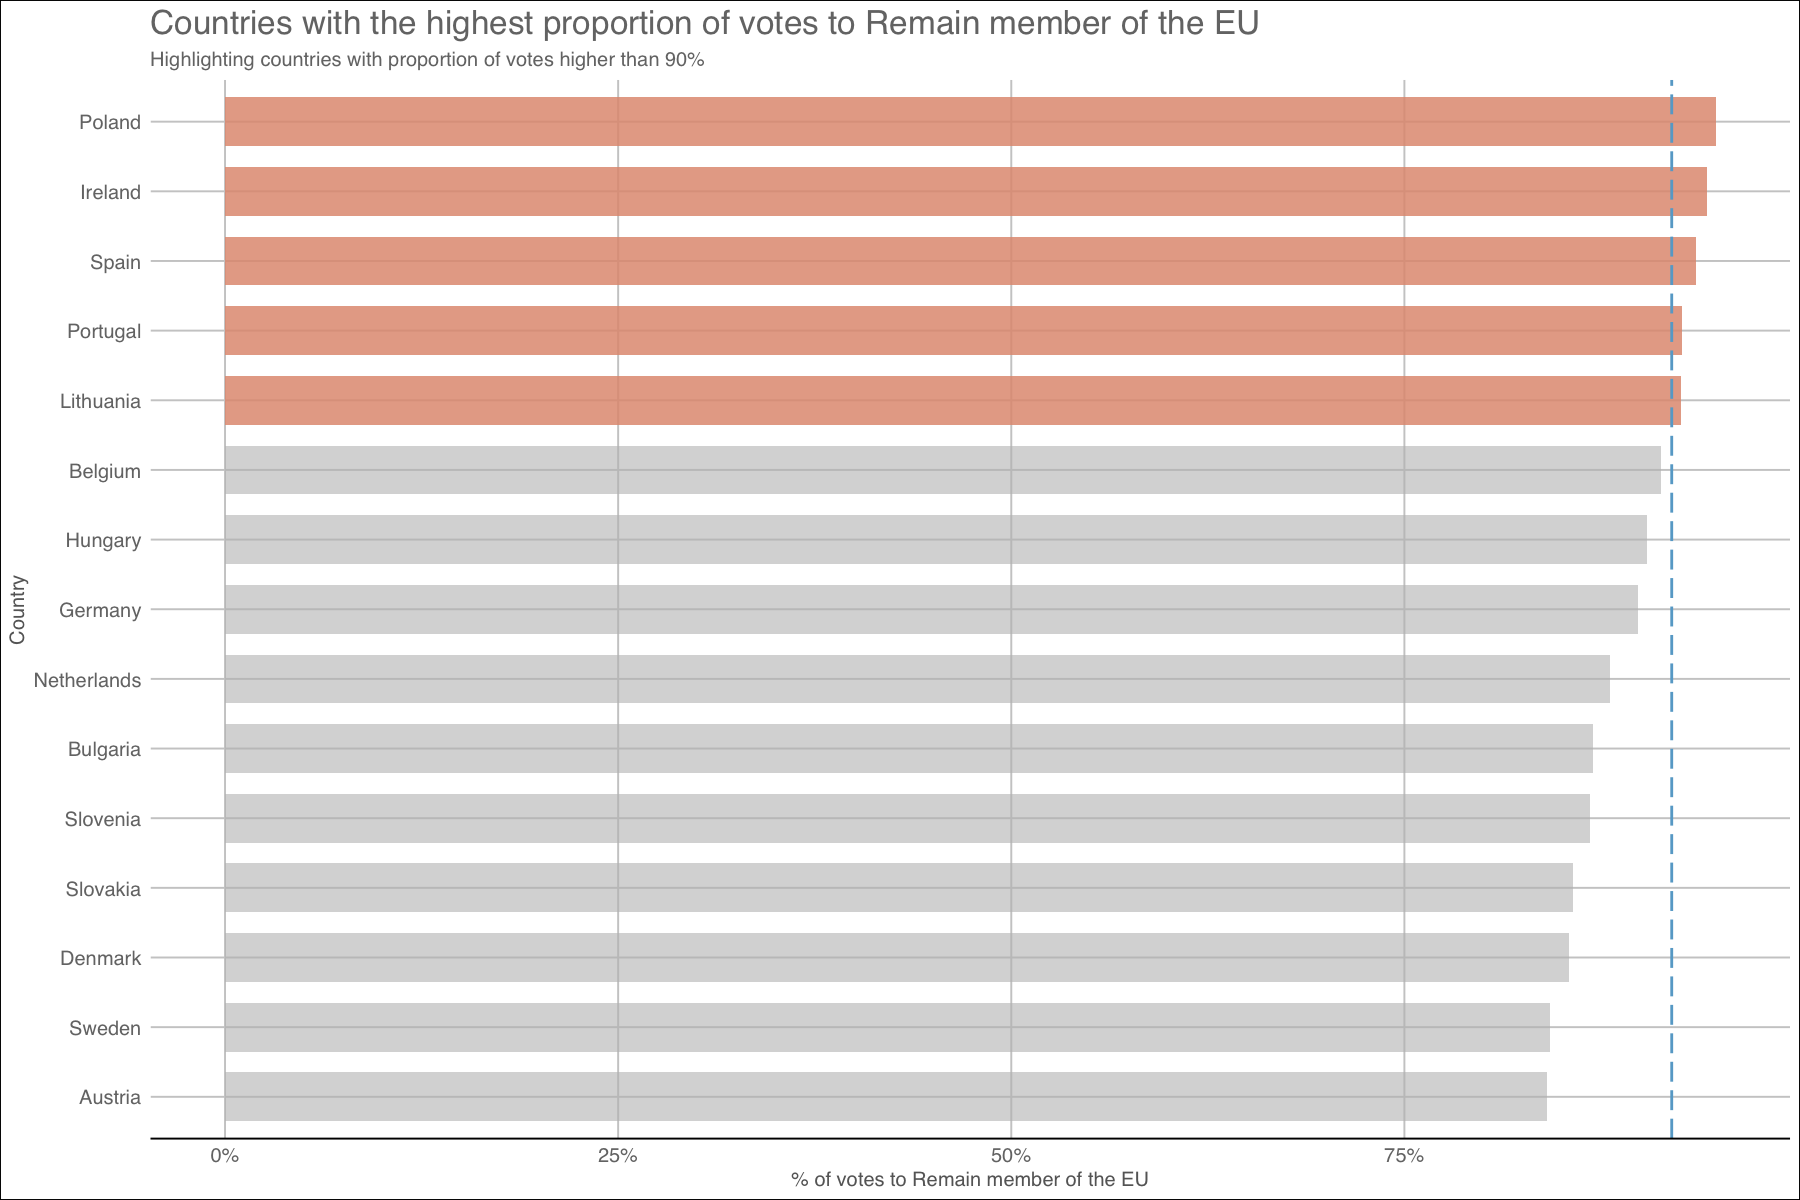

In [157]:
countries_by_Vote_Remain %>%
ggplot(aes(x=factor(cntry, levels = countries_by_Vote_Remain$cntry[order(prop)]), y=prop)) + 
    geom_bar(position="dodge",stat="identity", width = .7, fill="#ef8a62", alpha = .6) +
    gghighlight(max(prop) > 0.92) +
    geom_hline(aes(yintercept = 0.92), colour = "#67a9cf", linetype ="longdash", size = .8) +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "Country",
         y = "% of votes to Remain member of the EU",
         title = "Countries with the highest proportion of votes to Remain member of the EU",
         subtitle = "Highlighting countries with proportion of votes higher than 90%") +
    theme_gdocs() + coord_flip()

On the contrary Poland, Ireland, Spain, Portugal and Lithuania have more than **92%** of their population voting intentions to **Remain member of the EU**.

In order to spot insights let's have a deeper 

Hyphotesis: I believe when


## Education Overview

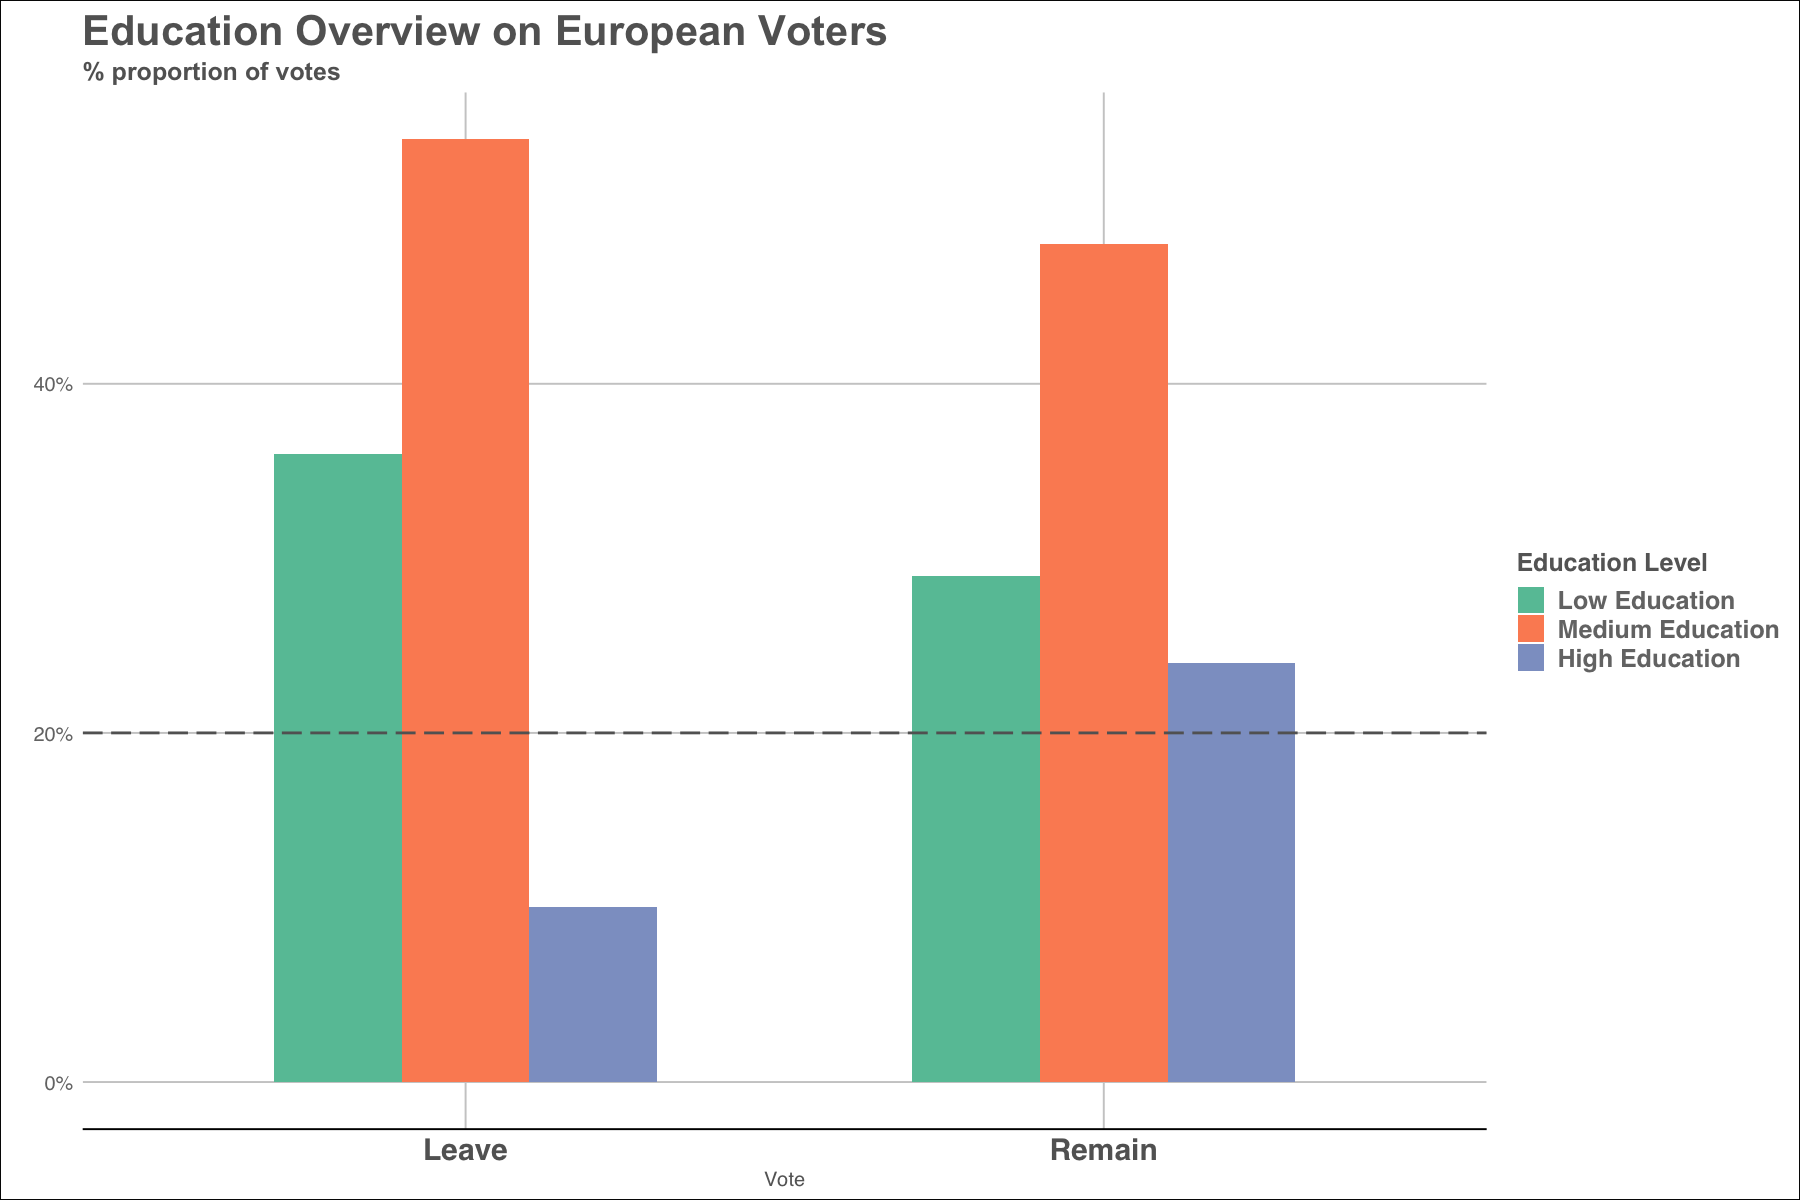

In [29]:
weighted_df_ess %>% 
    group_by(vteurmmb,Education) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    arrange(desc(Education,proportion)) %>%
    ggplot(aes(x= vteurmmb, y=proportion)) + 
    geom_bar(aes(fill=factor(Education,levels=c("Low Education","Medium Education","High Education"))),
             position="dodge",stat="identity", width = .6) +
    geom_hline(aes(yintercept = 0.20), colour = "#636363", linetype ="longdash", size = .8) +
    scale_fill_brewer(palette='Set2') +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "Vote",
        y = "",
        fill = "Education Level",
        title = "Education Overview on European Voters",
        subtitle = "% proportion of votes") + 
    theme_gdocs() + 
    theme(legend.title = element_text(size=15, face="bold"),
          legend.text = element_text(size=15, face="bold"),
          axis.text.x = element_text(face="bold", color="#636363", size=18),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

In [30]:
# Filtering the countries to use later on data viz
target_countries_l <- countries_by_Vote_Leave %>% arrange(desc(prop)) %>% head(5) %>% select(cntry)
target_countries_l$index <- seq.int(nrow(target_countries_l)) # adding an ordered index
target_countries_r <- countries_by_Vote_Remain %>% arrange(desc(prop)) %>% head(5) %>% select(cntry)
target_countries_r$index <- seq.int(nrow(target_countries_r))

In [31]:
countries_education_leave <- weighted_df_ess %>% 
    group_by(cntry,Education) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    filter(cntry %in% target_countries_l$cntry) %>% 
    arrange(desc(cntry,Education,proportion)) %>%
    ggplot(aes(x= factor(cntry, labels=target_countries_l$cntry), y=proportion)) + 
    geom_bar(aes(fill=factor(Education,levels=c("Low Education","Medium Education","High Education"))),
             position="dodge",stat="identity", width = .6) +
    geom_hline(aes(yintercept = 0.20), colour = "#8da0cb", linetype ="longdash", size = .8) +
    scale_fill_brewer(palette='Set2') +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "",
        y = "",
        fill = "Education",
        title = "Countries with highest proportion of votes to Leave the EU",
        subtitle = "Educational overview") + 
    theme_minimal() + 
    theme(legend.text = element_text(size=12, face="bold", color="#636363"),
          axis.text.x = element_text(face="bold", color="#636363", size=12),
          legend.title = element_blank(), 
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=12))

In [32]:
countries_education_remain <- weighted_df_ess %>% 
    group_by(cntry,Education) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    filter(cntry %in% target_countries_r$cntry) %>% 
    arrange(desc(cntry,Education,proportion)) %>%
    ggplot(aes(x= factor(cntry, labels=target_countries_r$cntry), y=proportion)) + 
    geom_bar(aes(fill=factor(Education,levels=c("Low Education","Medium Education","High Education"))),
             position="dodge",stat="identity", width = .6) +
    geom_hline(aes(yintercept = 0.20), colour = "#8da0cb", linetype ="longdash", size = .8) +
    scale_fill_brewer(palette='Set2') +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "",
        y = "",
        fill = "Education",
        title = "Countries with highest proportion of votes to Remain member of EU",
        subtitle = "Educational overview") + 
    theme_minimal() +
    theme(axis.text.x = element_text(face="bold", color="#636363", size=12),legend.position = "none", 
          plot.title=element_text(vjust=.5, face='bold', colour='#636363', size=15),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=12))

## Relationship between Educational Level and Vote

### Ploting a side by side education overview from countries that hold negative views of the EU and those that have strongly positive views of the political union.

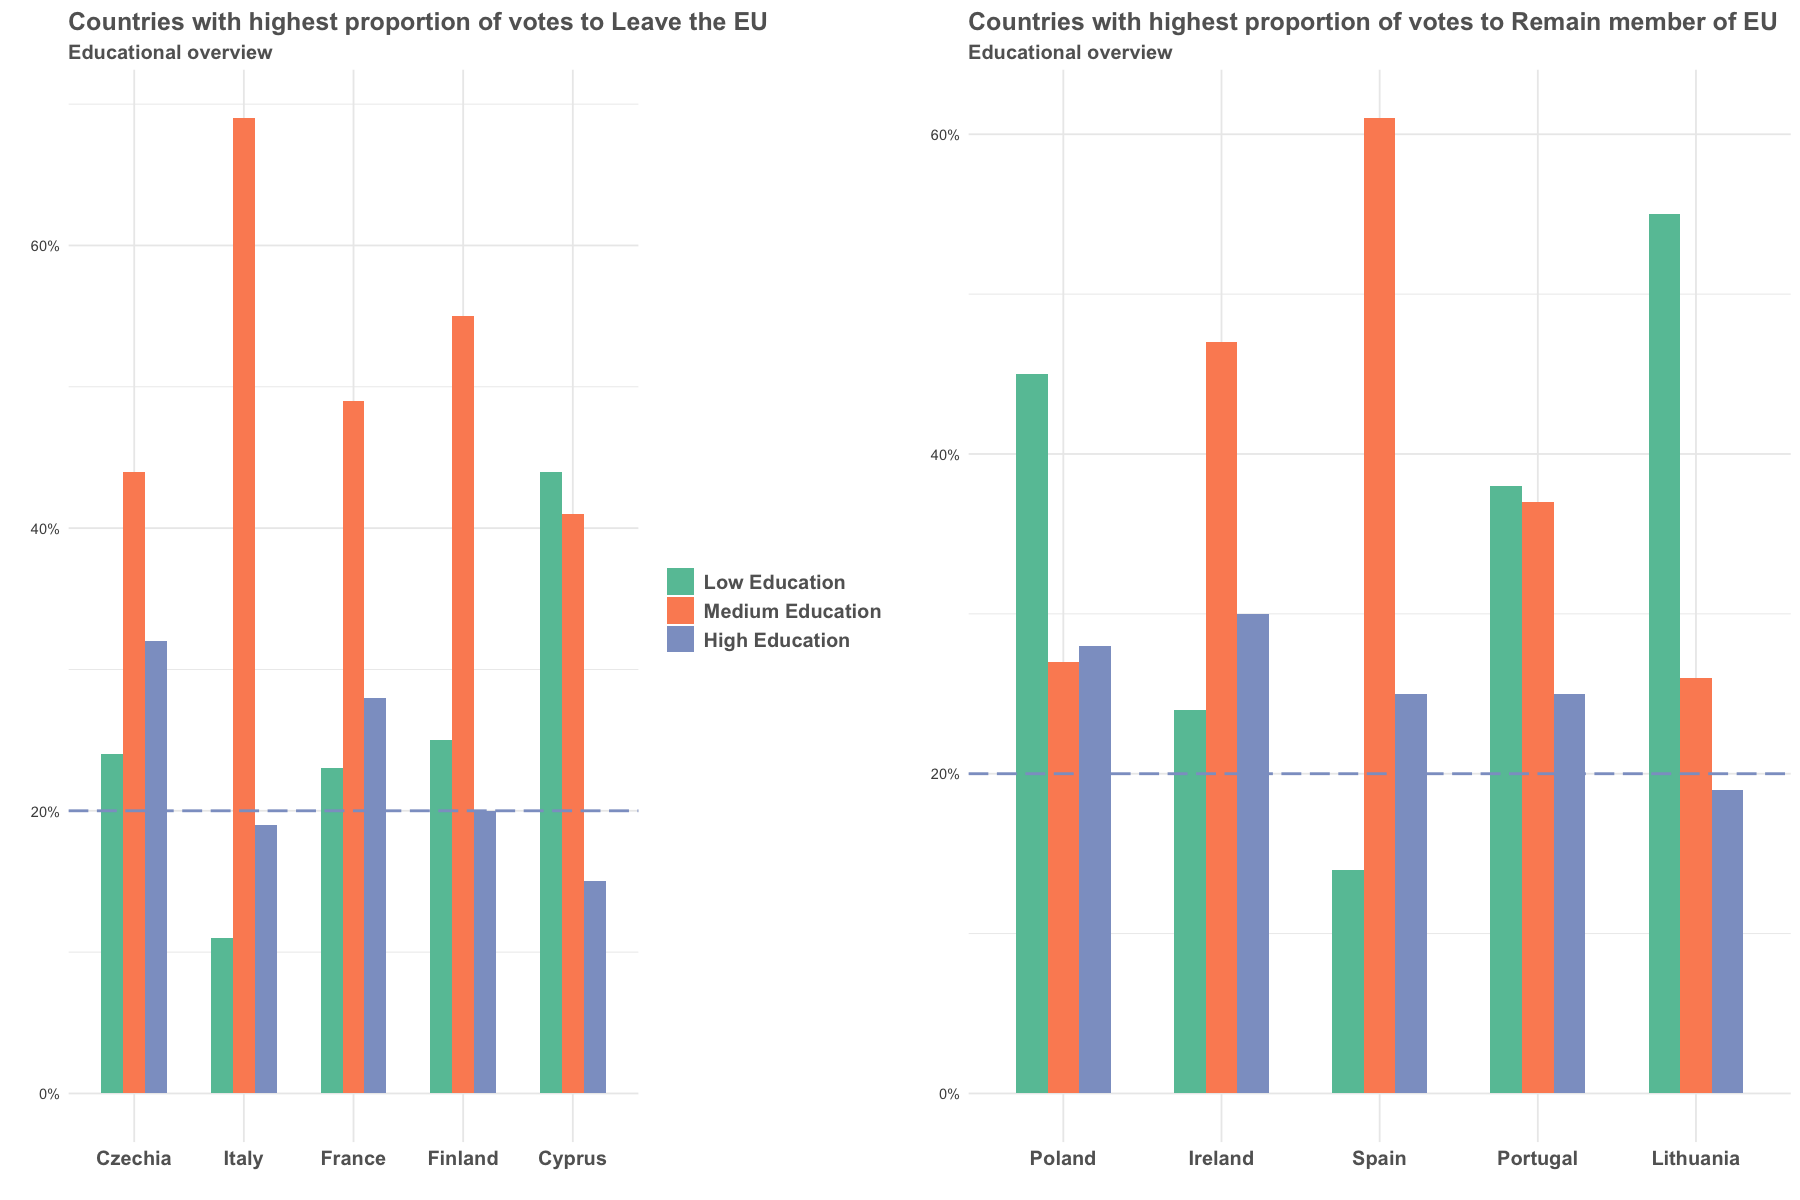

In [33]:
ggarrange(countries_education_leave, countries_education_remain, ncol = 2, nrow = 1)

From the countries that hold a positive outlook toward the EU only 2, Czechia and France, have more than 20% of their population with a High level of Education. From those countries that see the EU in a positive light only Lithuania have less that its population with a High level of Education.

Among those who voted for their country to Remain in EU the High Education it predominant as per Leave the EU Low Education is uppermost on almost all of Countries. It's worthwhile to investigate the relationship on them.

# Gender

Gender x Age
Gender x Unemployment
Gender x Union Membership
Gender x Vote

# Age Band Overview

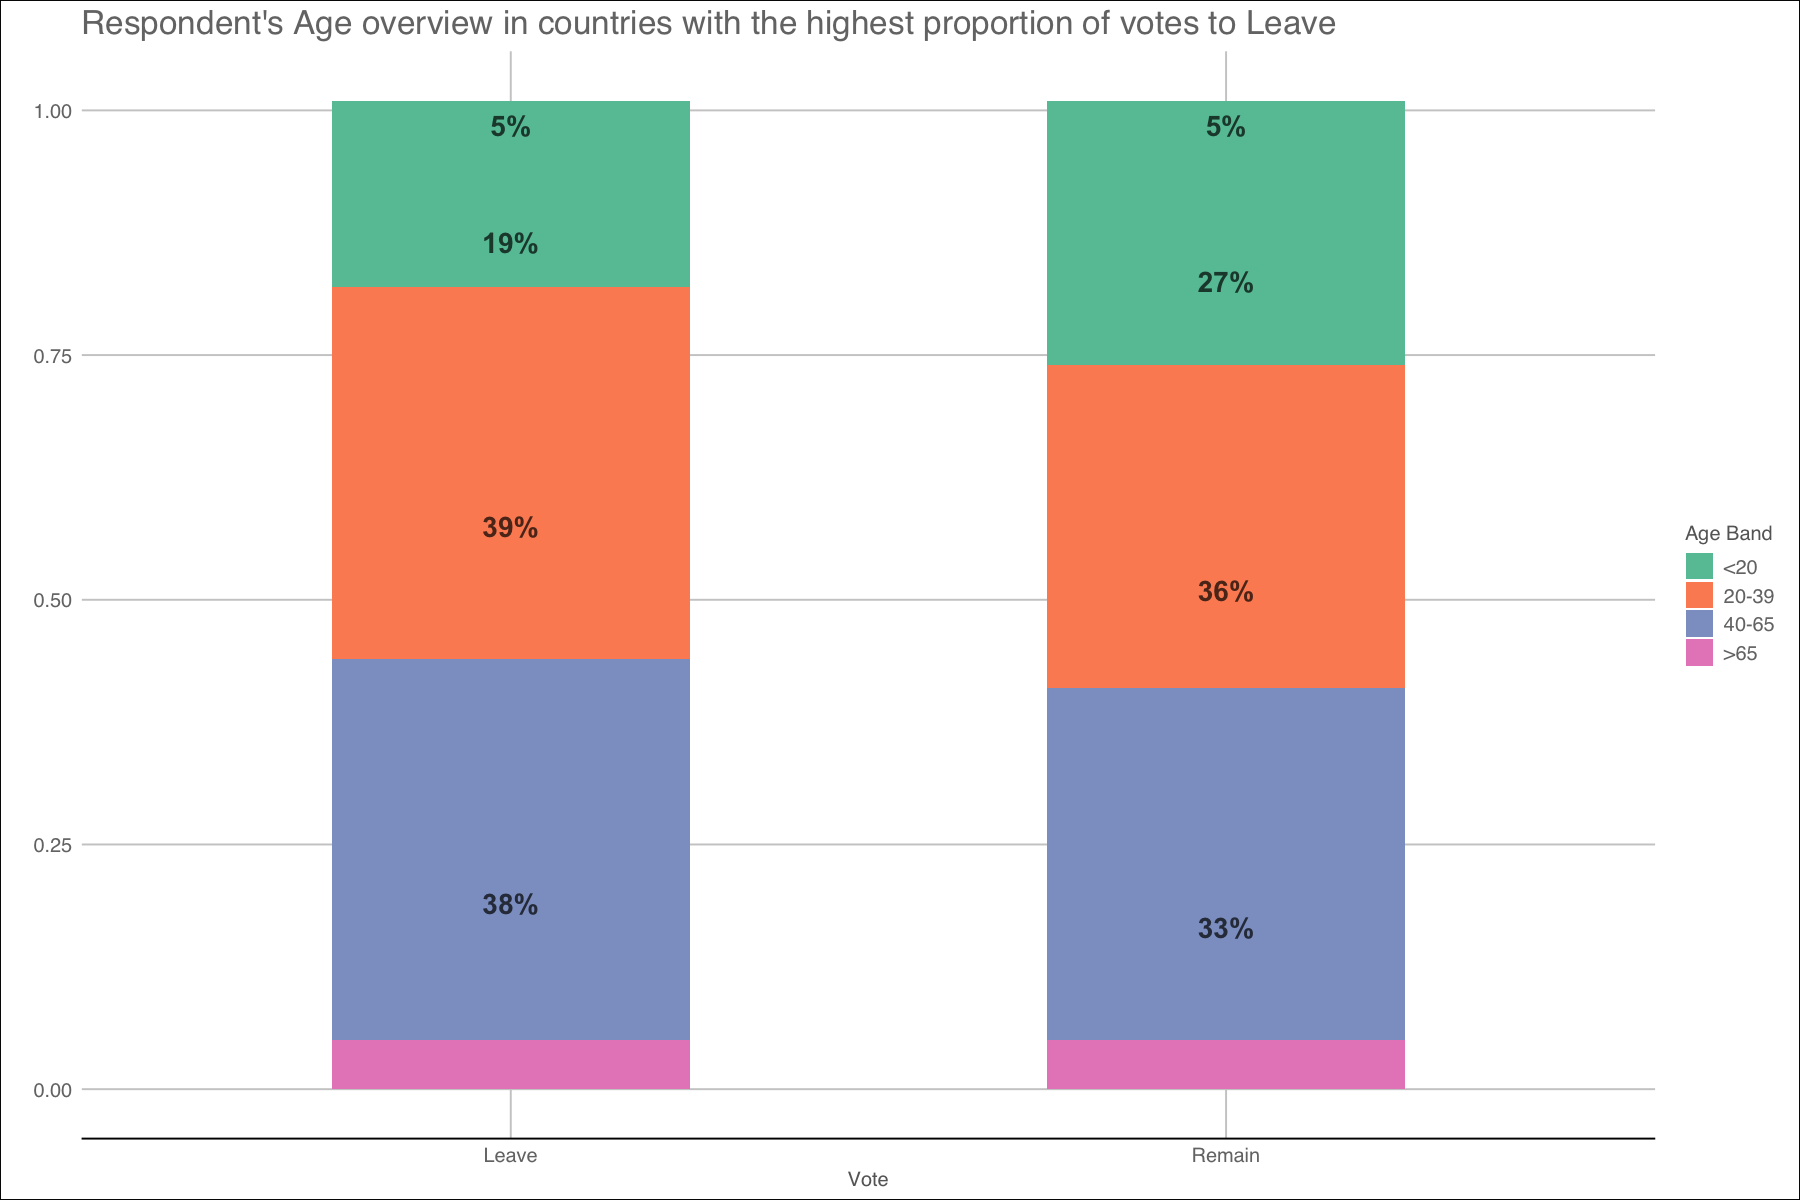

In [34]:
weighted_df_ess %>%
    group_by(vteurmmb,Age_Band) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
       label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= vteurmmb, y=proportion)) + 
    geom_bar(aes(fill=factor(Age_Band,levels=c("<20","20-39","40-65",">65"))),
             stat="identity",
             width = .5) +
    scale_fill_brewer(palette='Set2') +
    geom_text(aes(y=label_y, label = label), 
              col = "black", alpha=.7,
              size = 6,
              fontface = "bold") +
    labs(x = "Vote",
        y = "",
        fill = "Age Band",
        title = "Respondent's Age overview in countries with the highest proportion of votes to Leave") + 
    theme_gdocs()

# Unemployment

In [74]:
weighted_df_ess %>% 
    group_by(Region,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion)

Region,uemp3m,total,total_se,proportion,proportion_se,label,label_y
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Eastern Europe,No,3714.05,65.42,0.78,0.01,78%,0.390
Eastern Europe,Yes,1058.25,40.95,0.22,0.01,22%,0.890
Northern Europe,No,1590.28,19.28,0.70,0.01,70%,0.350
Northern Europe,Yes,678.31,15.49,0.30,0.01,30%,0.850
Southern Europe,No,5498.12,105.30,0.65,0.01,65%,0.325
Southern Europe,Yes,3014.68,84.79,0.35,0.01,35%,0.825
Western Europe,No,9483.30,245.34,0.68,0.01,68%,0.340
Western Europe,Yes,4440.53,159.67,0.32,0.01,32%,0.840


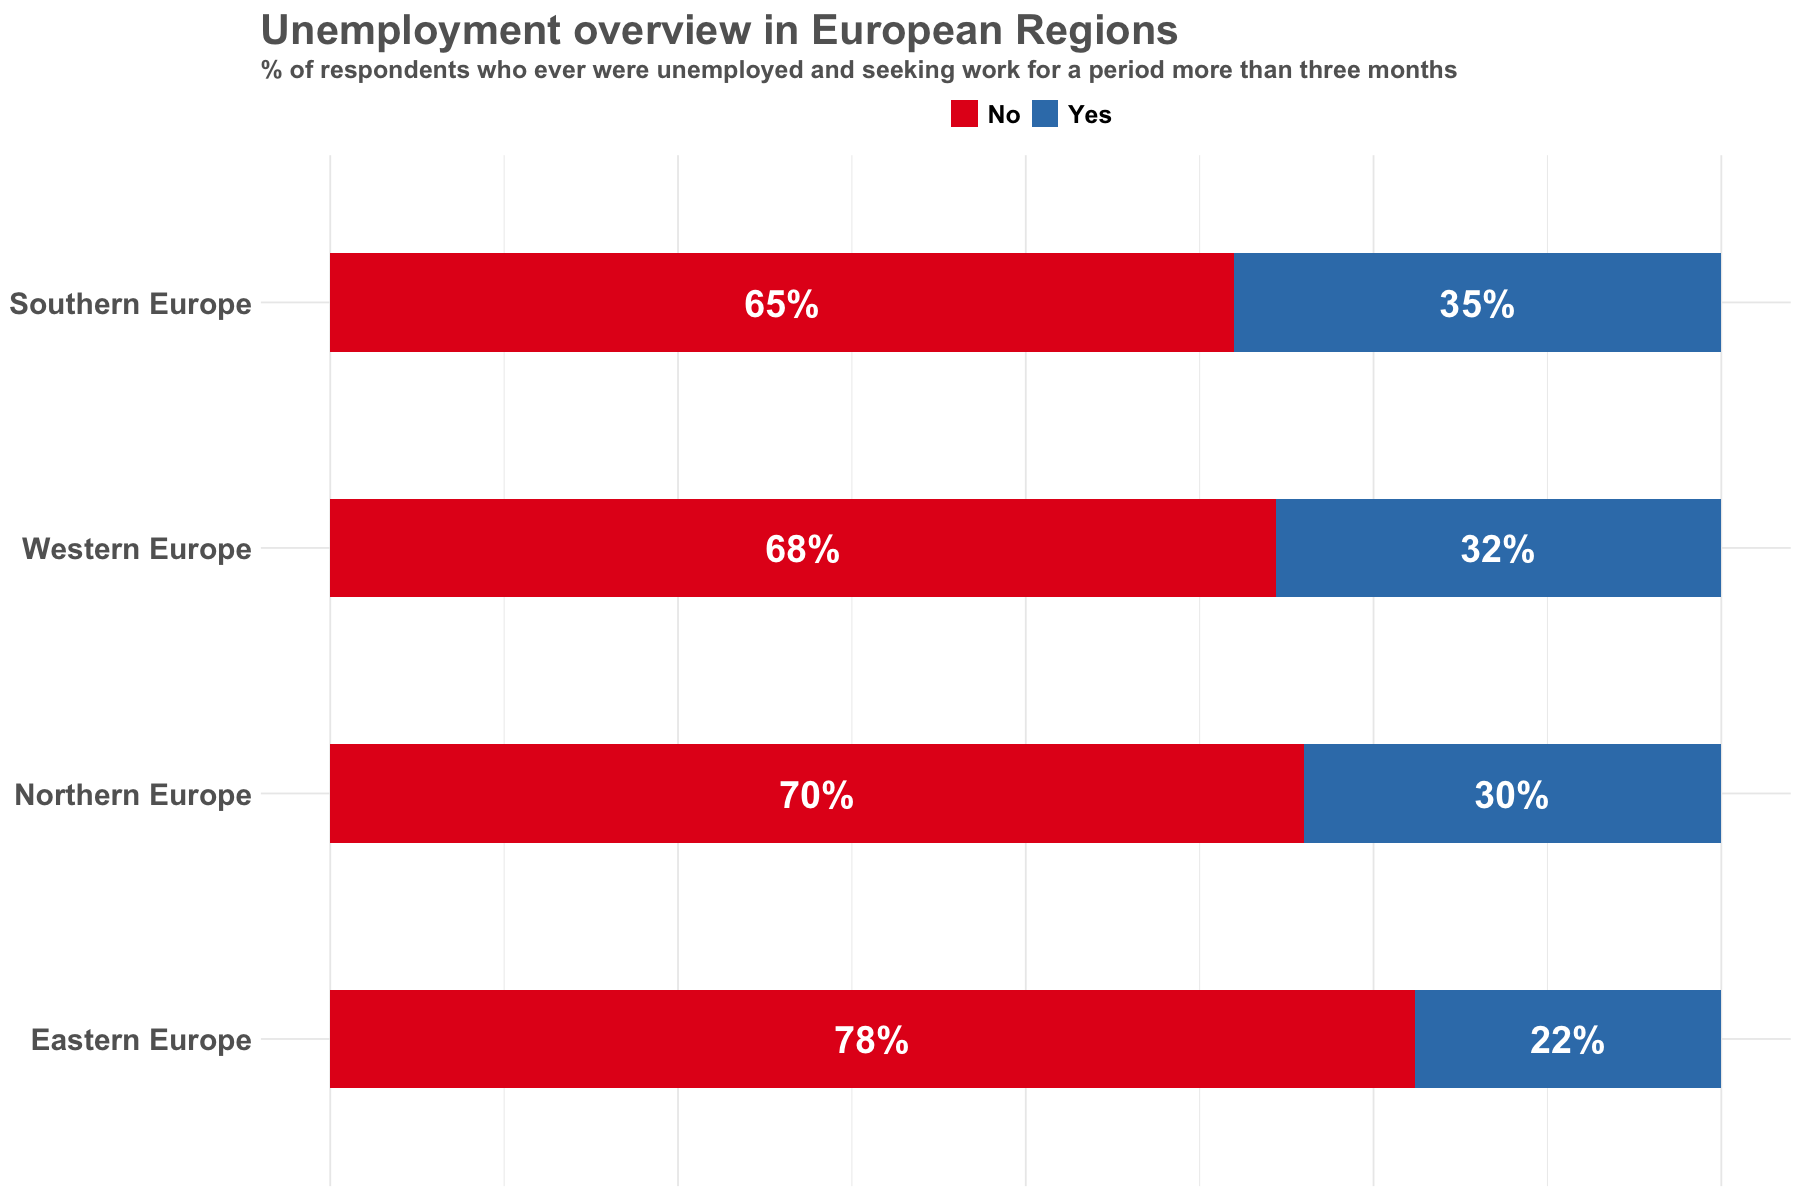

In [35]:
weighted_df_ess %>% 
    group_by(Region,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(Region, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE) ,stat="identity", width = .4) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 8,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment overview in European Regions",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

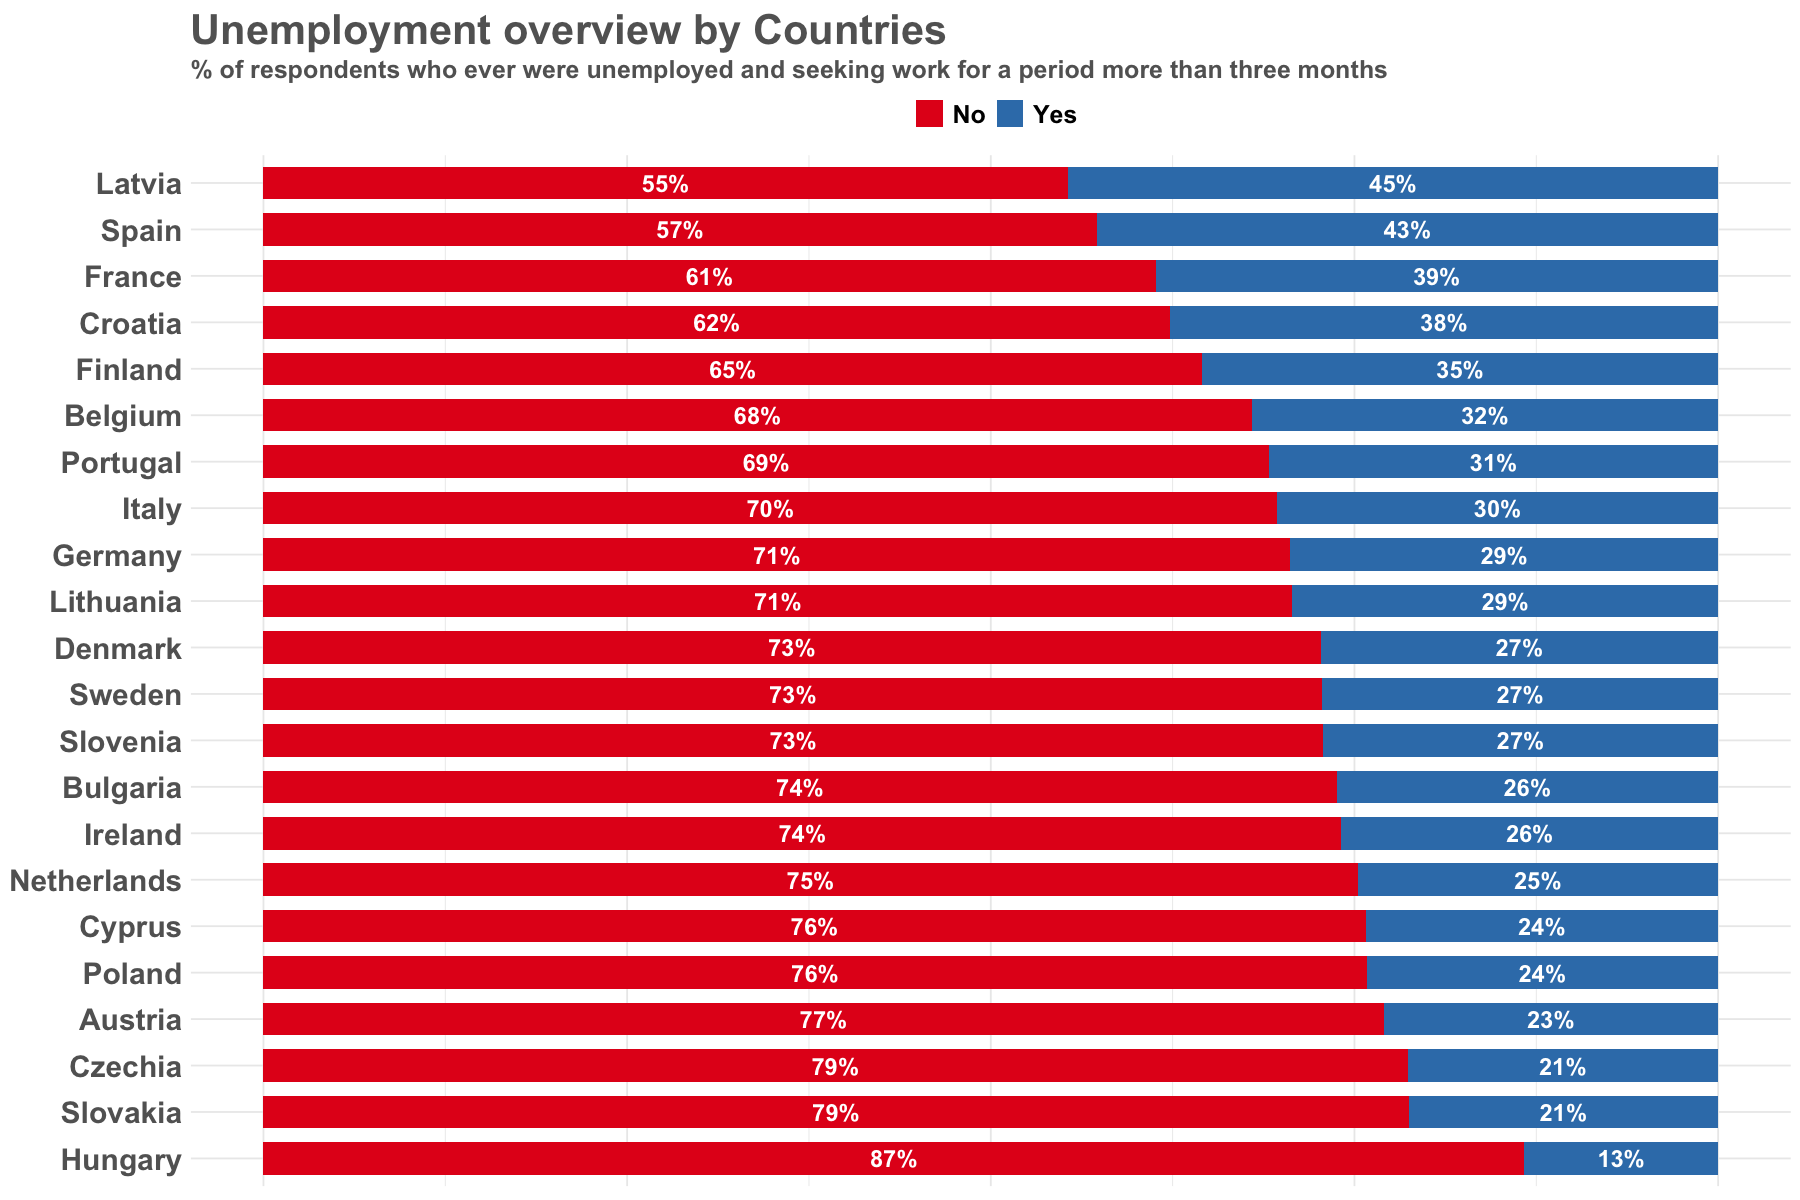

In [36]:
weighted_df_ess %>% 
    group_by(cntry,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = survey_mean()) %>%
    mutate(label = paste0(round(proportion * 100, 0), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(cntry, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE) ,stat="identity", width = .7) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 5,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment overview by Countries",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

## Relationship between Unemployment Status and Vote

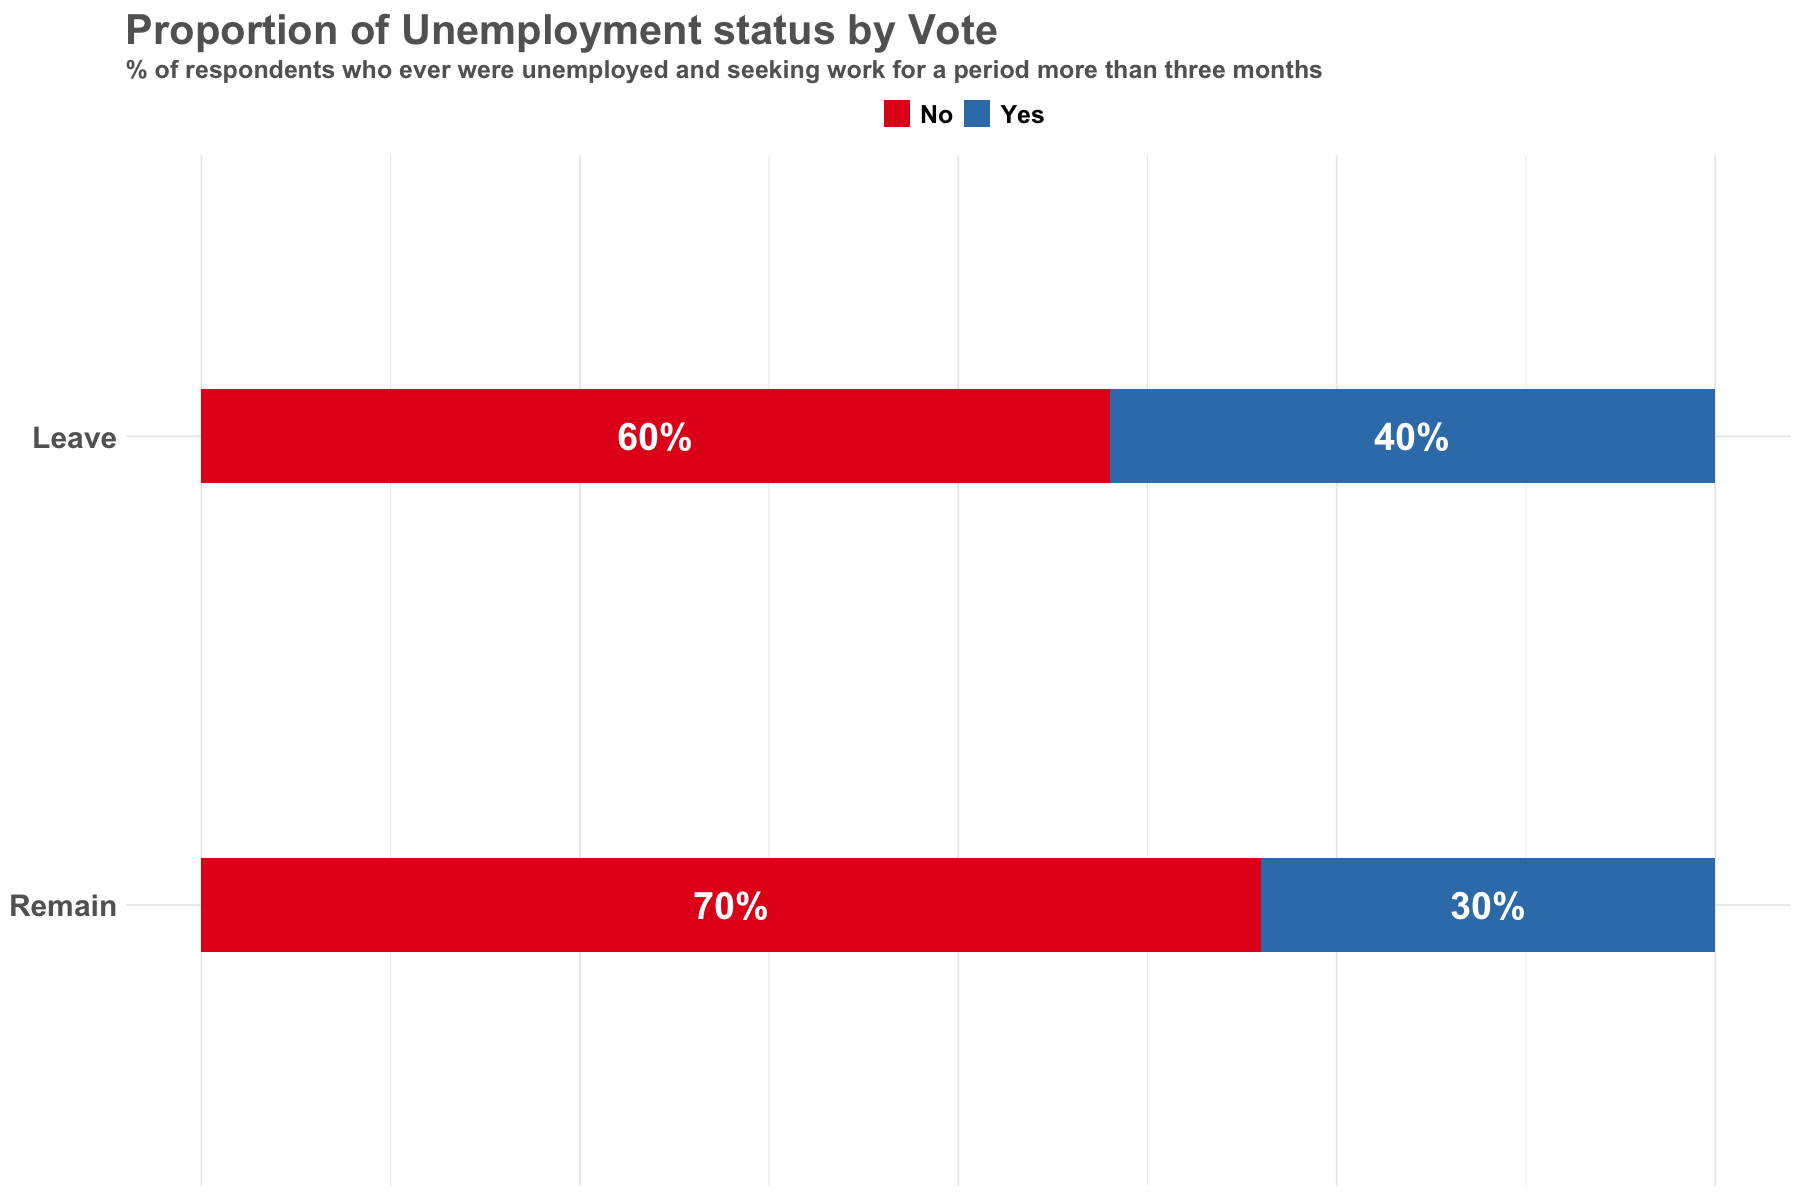

In [37]:
weighted_df_ess %>% 
    group_by(vteurmmb,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(vteurmmb, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE) ,stat="identity", width = .2) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 8,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Proportion of Unemployment status by Vote",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

In [38]:
employment_overview_leave <- weighted_df_ess %>% filter(cntry %in% target_countries_l$cntry) %>% 
    group_by(cntry,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion, 
           index = target_countries_l$index[cntry == target_countries_l$cntry]) %>%
    ggplot(aes(x= fct_reorder2(cntry, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE) ,stat="identity", width = .5) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 6,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment overview on top 5 countries with the highest proportion of votes to Leave",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_gdocs() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal", 
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=20),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

In [39]:
employment_overview_remain <- weighted_df_ess %>% filter(cntry %in% target_countries_r$cntry) %>% 
    group_by(cntry,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"),
           label_y = cumsum(proportion) - 0.5 * proportion, 
           index = target_countries_r$index[cntry == target_countries_r$cntry]) %>%
    ggplot(aes(x= fct_reorder2(cntry, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE), stat="identity", width = .5) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label),
              col = "white",
              hjust = 1.5,
              size = 6,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment overview on top 5 countries with the highest proportion of votes to Remain",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_gdocs() + 
    theme(legend.position = "top",
          legend.direction = "horizontal",
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=20),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

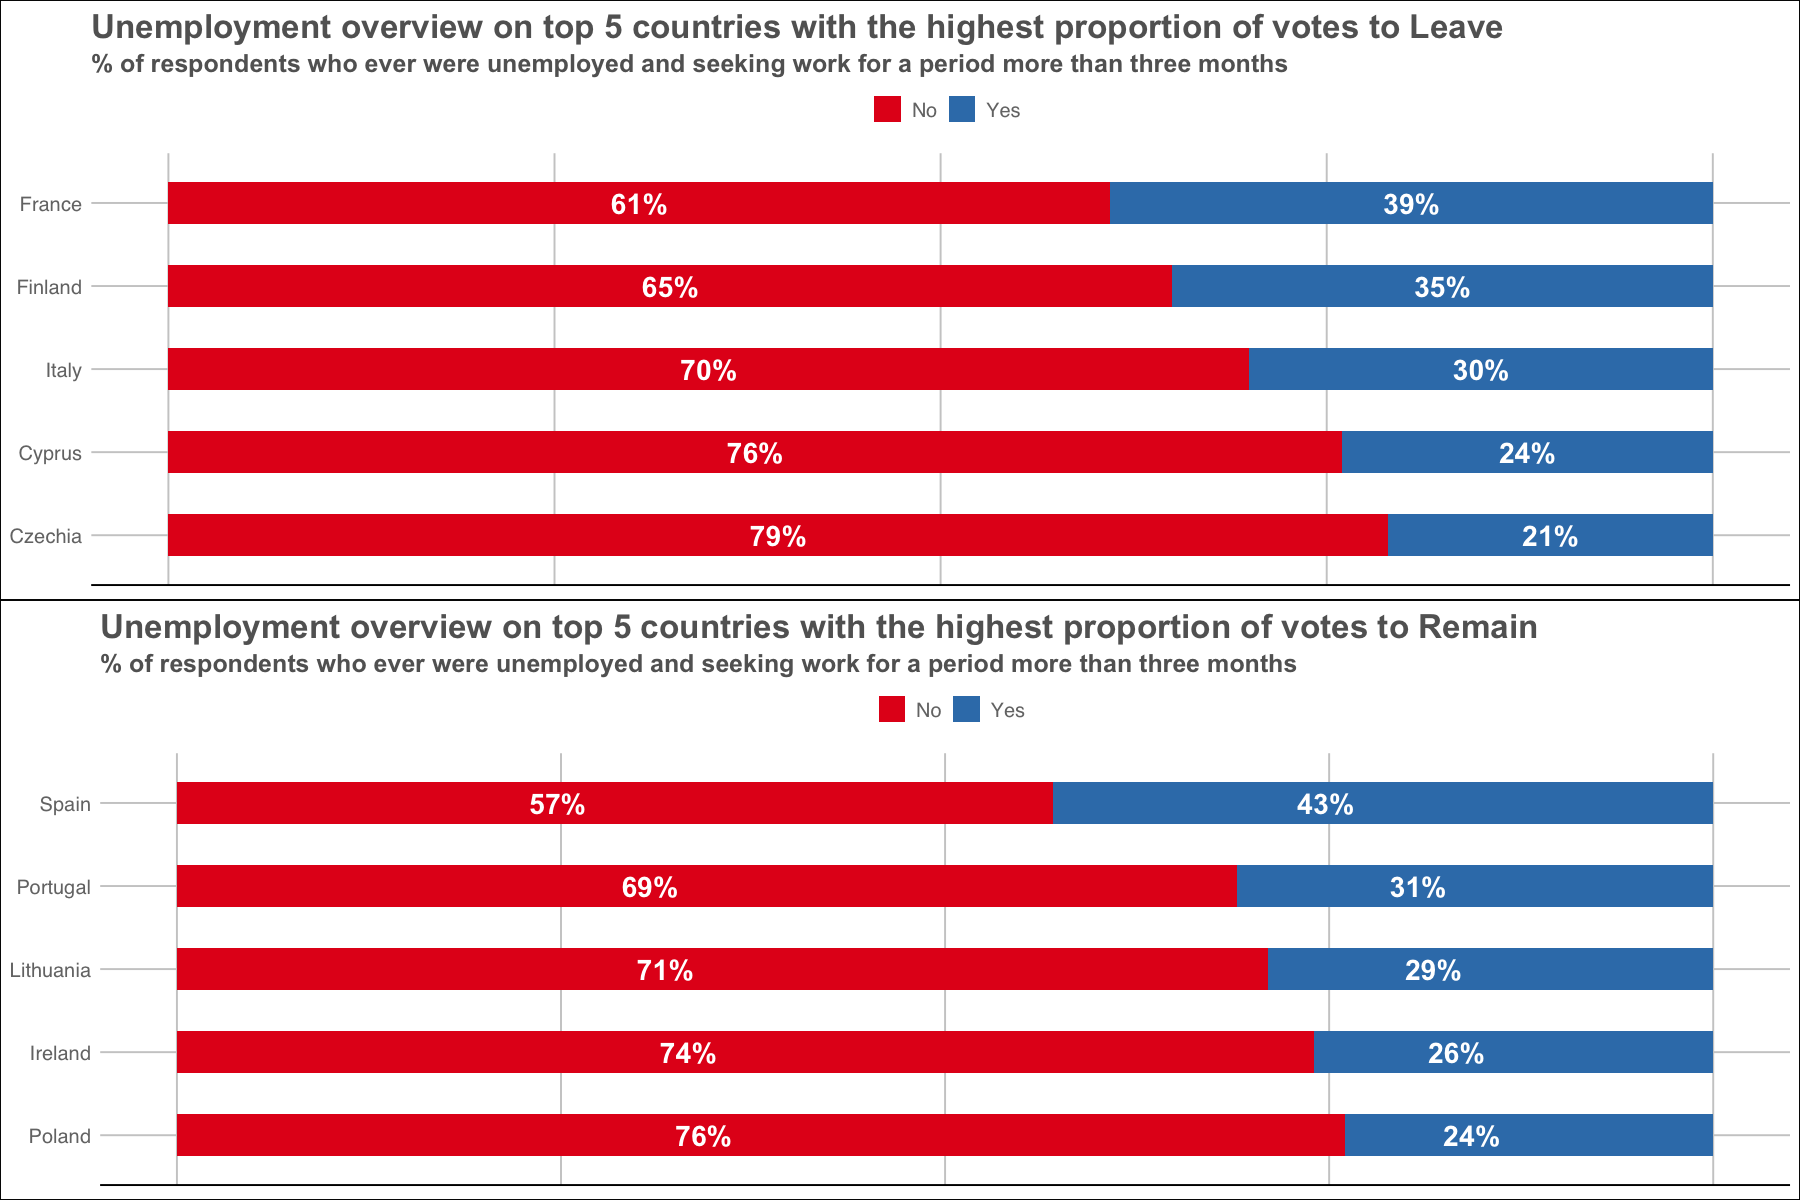

In [40]:
ggarrange(employment_overview_leave, employment_overview_remain, ncol = 1, nrow = 2)

# Union membership

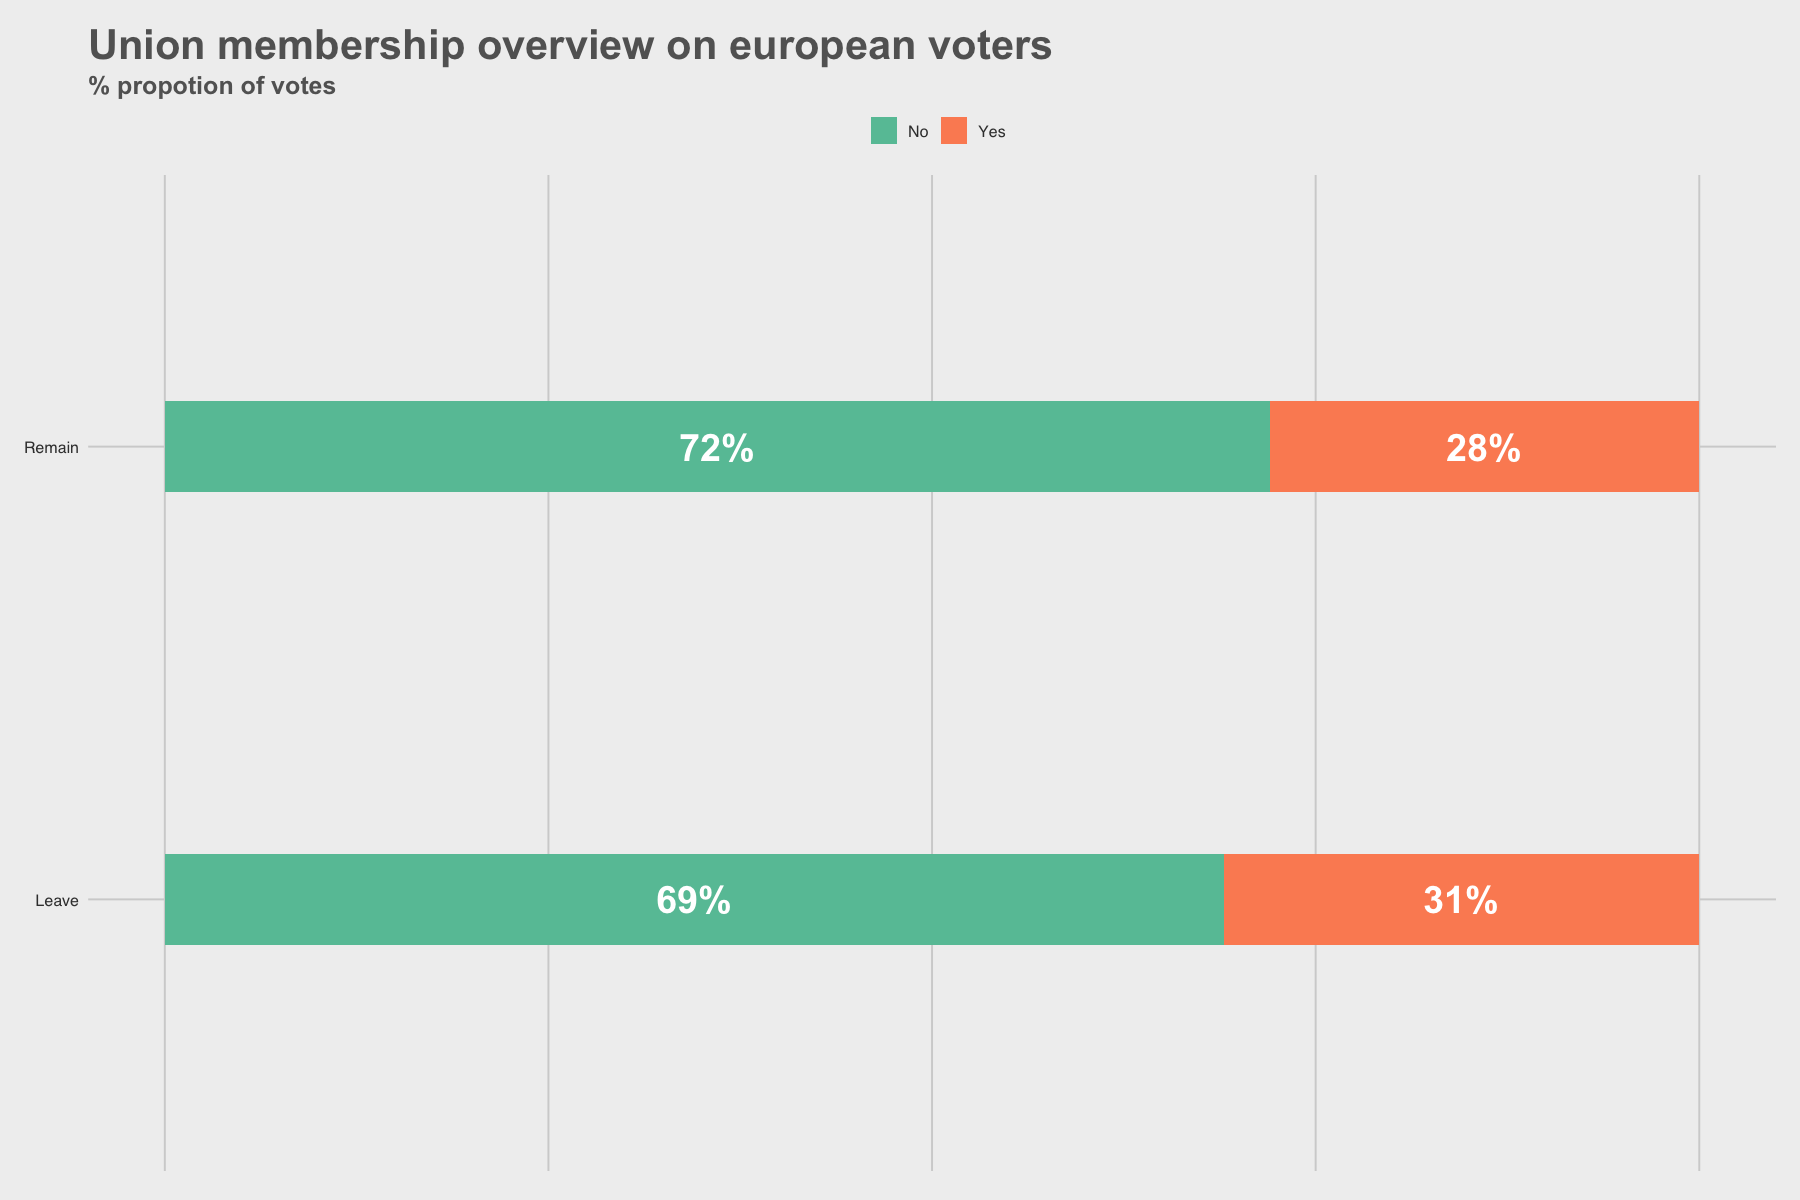

In [41]:
weighted_df_ess %>% 
    group_by(vteurmmb,mbtru) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= vteurmmb, y=proportion)) + 
    geom_bar(aes(fill=mbtru), position = position_stack(reverse = TRUE) ,stat="identity", width = .2) +
    scale_fill_brewer(palette='Set2') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 8,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Union membership overview on european voters",
        subtitle = "% propotion of votes")+ 
    theme_fivethirtyeight() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal", 
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

<a id="5"></a> <br>
<font size="+3" color="black"><b>5 - Previous Iterations</b></font><br><a id="5"></a>
<br> 

__Alternative for Proportion of votes__: Tried to a stacked bar graph but because Age <20 there is not much data it does not present well so I've switched Age and Vote

In [43]:
getRversion()

[1] ‘4.0.2’

In [44]:
str(weighted_df_ess$variables)
lm_eduyears_vote <- svyglm(vteurmmb ~ eduyrs+Education+uemp3m+mbtru+agea+Age_Band+gndr, design=weighted_df_ess, family=binomial)
summary(lm_eduyears_vote, df.resid = degf(weighted_df_ess))
predict_european_survey <- weighted_df_ess

# Predictions
predict_european_survey$variables$probs <- predict(lm_eduyears_vote, 
                                                  newdata = predict_european_survey, 
                                                  type = "response")
# setting a significance
predict_european_survey <- predict_european_survey %>% mutate(evs1 = ifelse(probs > 0.9, yes = 1, no = 0))
predict_european_survey$variables$evs1 <- as.factor(predict_european_survey$variables$evs1)

summary(predict_european_survey$variables$evs1)

predict_european_survey$variables

# What's the probability for a person with 13 years of education, unemployed and 
# which have not been a trade union member to vote for the the country to leave the UE?
person1 <- predict(lm_eduyears_vote,
                   newdata = data.frame(eduyrs = 13, uemp3m = 'Yes', mbtru = 'No'),
                   type = "response")

paste0(round(person1*100,2), "%")

# Creating a plot to check hyphotesis 3
educational_profile <- data.frame(eduyrs = seq(from = 0, to = 50, by = .5))

educational_profile$predicted_probs <- predict(lm_eduyears_vote, 
                                              newdata = educational_profile, 
                                              type = "response")

# Plot: Vote for Years of Education
ggplot(educational_profile, 
       aes(x = eduyrs, y = predicted_probs)) + 
  geom_line(alpha = 0.5) + 
  ylab("Probability to vote for Leave the UE") + 
  xlab("Years of Education") + 
  ggtitle("Vote for Leave the UE by Years of Education")

tibble [32,284 × 15] (S3: tbl_df/tbl/data.frame)
 $ cntry    : Factor w/ 29 levels "Austria","Belgium",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ eduyrs   : num [1:32284] 13 13 13 12 9 14 13 12 13 13 ...
 $ eisced   : Factor w/ 7 levels "ES-ISCED I , less than lower secondary",..: 4 4 2 4 2 4 4 4 4 4 ...
 $ uemp3m   : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ mbtru    : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 2 1 1 1 ...
 $ vteurmmb : Factor w/ 2 levels "Leave","Remain": 2 2 1 2 2 2 2 1 1 2 ...
 $ yrbrn    : Factor w/ 77 levels "1928","1929",..: 48 24 51 28 20 27 35 17 54 43 ...
 $ agea     : num [1:32284] 29 53 26 49 57 50 42 60 23 34 ...
 $ gndr     : Factor w/ 2 levels "Male","Female": 1 1 2 1 2 1 1 2 1 1 ...
 $ anweight : num [1:32284] 0.0659 0.1249 0.6858 0.1168 0.3118 ...
 $ psu      : num [1:32284] 1688 88 938 1998 601 ...
 $ stratum  : num [1:32284] 59 79 11 74 99 77 36 69 9 82 ...
 $ Education: Factor w/ 3 levels "High Education",..: 3 3 2 3 2 3 3 3 3 3 ...
 $ Age_Band 


Call:
svyglm(formula = vteurmmb ~ eduyrs + Education + uemp3m + mbtru + 
    agea + Age_Band + gndr, design = weighted_df_ess, family = binomial)

Survey design:
Called via srvyr

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                1.831876   0.271293   6.752 1.51e-11 ***
eduyrs                     0.054528   0.011410   4.779 1.78e-06 ***
EducationLow Education    -0.655043   0.130105  -5.035 4.84e-07 ***
EducationMedium Education -0.759148   0.093305  -8.136 4.42e-16 ***
uemp3mYes                 -0.379146   0.057428  -6.602 4.20e-11 ***
mbtruYes                  -0.154649   0.062553  -2.472  0.01344 *  
agea                      -0.004367   0.004242  -1.030  0.30319    
Age_Band40-65              0.286755   0.113020   2.537  0.01118 *  
Age_Band<20                0.354549   0.119097   2.977  0.00292 ** 
Age_Band>65                0.465431   0.217676   2.138  0.03252 *  
gndrFemale                 0.139729   0.057075   2.448  0

0     1 
21991 10293

cntry,eduyrs,eisced,uemp3m,mbtru,vteurmmb,yrbrn,agea,gndr,anweight,psu,stratum,Education,Age_Band,Region,probs,evs1
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<svystat>,<fct>
Austria,13,"ES-ISCED IIIb, lower tier upper secondary",No,No,Remain,1975,29,Male,0.06588958,1688,59,Medium Education,20-39,Western Europe,0.8395575,0
Austria,13,"ES-ISCED IIIb, lower tier upper secondary",No,Yes,Remain,1951,53,Male,0.12490674,88,79,Medium Education,40-65,Western Europe,0.8431994,0
Austria,13,"ES-ISCED II, lower secondary",No,No,Leave,1978,26,Female,0.68583600,938,11,Low Education,20-39,Western Europe,0.8712297,0
Austria,12,"ES-ISCED IIIb, lower tier upper secondary",No,No,Remain,1955,49,Male,0.11675334,1998,74,Medium Education,40-65,Western Europe,0.8581269,0
Austria,9,"ES-ISCED II, lower secondary",No,No,Remain,1947,57,Female,0.31178924,601,99,Low Education,40-65,Western Europe,0.8635542,0
Austria,14,"ES-ISCED IIIb, lower tier upper secondary",No,Yes,Remain,1954,50,Male,0.17386711,68,77,Medium Education,40-65,Western Europe,0.8519349,0
Austria,13,"ES-ISCED IIIb, lower tier upper secondary",Yes,Yes,Remain,1962,42,Male,0.21768841,1139,36,Medium Education,40-65,Western Europe,0.7943132,0
Austria,12,"ES-ISCED IIIb, lower tier upper secondary",No,No,Leave,1944,60,Female,0.03930598,1914,69,Medium Education,40-65,Western Europe,0.8689272,0
Austria,13,"ES-ISCED IIIb, lower tier upper secondary",No,No,Leave,1981,23,Male,0.53493134,885,9,Medium Education,20-39,Western Europe,0.8430559,0


ERROR: Error in eval(predvars, data, env): objeto 'Education' não encontrado
